In [139]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS



import warnings
warnings.filterwarnings("ignore")

### Preface

This notebook just explores the employment analysis part of the paper ["The Consumption Response to Trade Shocks: Evidence from the US-China Trade War."](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/waugh_consumption.pdf) . This is in Section 5. It mimics many parts of the auto analysis (visualization, tabular representations, and regression analysis). Below I also report the unweighted an weighted regression results.

### Steup for analysis

Just some basic things, bring in the data, make the transformations that we want, etc...

In [140]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

This is the cell below to change if you want to toggle between all employment and only goods producing employment.

In [141]:
file_path = os.getcwd()

#trade_county = pq.read_table(file_path + "\\data\\trade_employment_goods.parquet").to_pandas()

trade_county = pq.read_table(file_path + "\\data\\trade_employment_2014.parquet").to_pandas()

In [142]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [143]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

emp_measure = "emp_gds"
# Here you specify the type of employment you want. emp_all is total employment. emp_gds = goods employment. 

trade_county["log_employment"] = np.log(trade_county[emp_measure]).replace(-np.inf, np.nan)
# Now given how the file is setup, we can select which type of employment.
# all private, goods, or manufacturing.

trade_county["log_employment_nt"] = np.log(trade_county["emp_all"] - 
                                          trade_county["emp_gds"]).replace(-np.inf, np.nan)

trade_county["const"] = 1

In [144]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [145]:
trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [146]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017  fips  \
GEOFIPS time                                                                  
10001   2014-01-01           NaN           NaN  1.069526          NaN  None   
        2014-02-01           NaN           NaN  1.069526          NaN  None   
        2014-03-01           NaN           NaN  1.069526          NaN  None   
        2014-04-01           NaN           NaN  1.069526          NaN  None   
        2014-05-01           NaN           NaN  1.069526          NaN  None   

                    total_employment  emp_all  emp_gds  emp_n_gds  \
GEOFIPS time                                                        
10001   2014-01-01           29514.0      0.0      0.0    37089.0   
        2014-02-01           29514.0      0.0      0.0    37024.0   
        2014-03-01           29514.0      0.0      0.0    37254.0   
        2014-04-01           29514.0      0.0      0.0    37875.0   
        2014-05-01           29514.0      0.0      0.0    38005.0   

                    rural_share  2010_population  2017_income  \
GEOFIPS time                                                    
10001   2014-01-01     0.269694         162310.0      57647.0   
        2014-02-01     0.269694         162310.0      57647.0   
        2014-03-01     0.269694         162310.0      57647.0   
        2014-04-01     0.269694         162310.0      57647.0   
        2014-05-01     0.269694         162310.0      57647.0   

                    2017_population  log_tariff  log_exp_total  log_exp_china  \
GEOFIPS time                                                                    
10001   2014-01-01         173145.0    0.010638            NaN            NaN   
        2014-02-01         173145.0    0.010638            NaN            NaN   
        2014-03-01         173145.0    0.010638            NaN            NaN   
        2014-04-01         173145.0    0.010638            NaN            NaN   
        2014-05-01         173145.0    0.010638            NaN            NaN   

                    log_employment  log_employment_nt  const state_fips  
GEOFIPS time                                                             
10001   2014-01-01             NaN                NaN      1         10  
        2014-02-01             NaN                NaN      1         10  
        2014-03-01             NaN                NaN      1         10  
        2014-04-01             NaN                NaN      1         10  
        2014-05-01             NaN                NaN      1         10

### Simple Cuts of Employment Data by Tariff Exposure

Here is the strategy. First, compute the quantiles of tariff exposure for each county. Then compute year over year sales growth for each county. Note that since this is in growth rates, this takes out any county level "fixed effect" and removes any seasonal component. 

Then we will simply plot year over year employment growth, for the (mean or median) county in a particular part of the distribution of tariff exposure.

This stuff is not reported in the paper, but is here to mimic the results for the autos.

Note the stuff below will also replicate the summary statistics in the paper.

In [147]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.
trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["nt_employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment_nt.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [148]:
# Then what we will do is look at the change in the taiff distribution...

exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff_change, 4 ,labels = False)

#median_exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).alt_tariff, 5 ,labels = False)

In [149]:
most_exposed = exposure[exposure == 3].index.tolist()

mid_group = exposure.isin([1,2])

med_exposed = exposure[mid_group].index.tolist()

least_exposed = exposure[exposure == 0].index.tolist()

trade_county.xs('2018-12-1', level=1).tariff_change.mean()


1.5077290482672434

In [150]:
print("Tariff Change-Most:", round(trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Midl:", round(trade_county.loc[med_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Lest:",round(trade_county.loc[least_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Mean:", round(trade_county.xs('2018-12-1', level=1).tariff_change.mean(),2))

Tariff Change-Most: 3.79
Tariff Change-Midl: 1.05
Tariff Change-Lest: 0.15
Tariff Change-Mean: 1.51


In [151]:
print("Chinese Exports 2017, (Most, Middle, Least, Mean)")

measure = "china_exp_pc"

print(round(trade_county.loc[most_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.groupby("time").agg({measure:"mean"}).loc["2017"].sum()[0],0))

Chinese Exports 2017, (Most, Middle, Least, Mean)
4034.0
1289.0
347.0
1879.0


In [152]:
print("Annual Employment, (Most, Middle, Least, Mean)")

print(round(trade_county.loc[most_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.groupby("time").agg({emp_measure:"mean"}).loc["2017"].mean()[0],0))

Annual Employment, (Most, Middle, Least, Mean)
4175.0
9562.0
3168.0
6624.0


Now we will plot a comparision between those who are most exposed and those whoe are the least exposed (in terms of changes). This is basically the difference in difference by visualization.

In [153]:
empl_most = trade_county.loc[most_exposed].groupby("time").agg({"employment_growth":"mean"})

empl_least = trade_county.loc[least_exposed].groupby("time").agg({"employment_growth":"mean"})

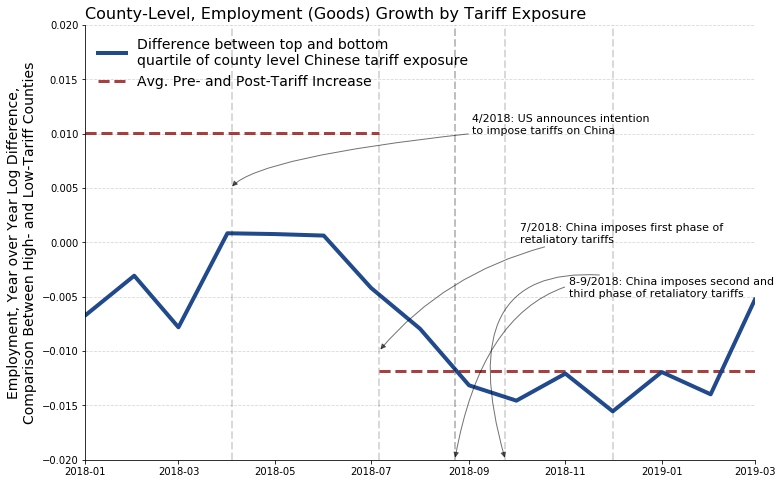

In [154]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot((empl_most - empl_least), alpha = 0.95, color = mike_blue, linewidth = 4, 
        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_ylim(-0.02,0.02)

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.set_ylabel("Employment, Year over Year Log Difference,\nComparison Between High- and Low-Tariff Counties", fontsize = 14)

ax.hlines((empl_most - empl_least).loc[:"2018-07-01"].mean().iloc[0],
          dt.datetime(2018,1,1),dt.datetime(2018,7,6),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--")

ax.hlines((empl_most - empl_least).loc["2018-08-01":].mean().iloc[0],
          dt.datetime(2018,7,6),dt.datetime(2019,3,1),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--", label = "Avg. Pre- and Post-Tariff Increase")

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.legend(loc = 0, frameon  = False, fontsize = 14)

ax.set_title("County-Level, Employment (Goods) Growth by Tariff Exposure", fontsize = 16, loc= "left" )

##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 0.005), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,9,3), 0.01), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -0.01), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,10,3), 0.0), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -0.02), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -0.02), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=286",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

#plt.savefig(fig_path + "\\simple_employment_county_all.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

Then this will do the tabular representation using stuff before and after the first phase of the tradewar.

In [155]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0182 0.001 4704
0.0208 0.002 4488


In [156]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0156 0.001 7059
0.0265 0.002 6738


Not discussed in the paper, but what this looks like is that both looked relativly the same before the start of it interms of employment growth. But after the first phase, the least exposed did really well (this is consistent with a rocking US economy) but those most exposed did relativly poorly. But growth here is still positive. 

### Regression Analysis

This will walk through the results using employment data. The first set are the main (weighted results). The next set are the unweighted results. Numbers may not exactly match up to what is in the paper as some rounding is occuring. 

In [157]:
trade_county.columns

Index(['total_exp_pc', 'china_exp_pc', 'tariff', 'emplvl_2017', 'fips',
       'total_employment', 'emp_all', 'emp_gds', 'emp_n_gds', 'rural_share',
       '2010_population', '2017_income', '2017_population', 'log_tariff',
       'log_exp_total', 'log_exp_china', 'log_employment', 'log_employment_nt',
       'const', 'state_fips', 'tariff_change', 'log_tariff_change',
       'employment_growth', 'nt_employment_growth'],
      dtype='object')

### Weighted Results

#### Change on Change, no time or fixed effects

In [158]:
start = "2018-01-01"

weighting_var = "total_employment"

In [159]:
all_vars = ["const", "log_tariff_change", 'employment_growth',"2017_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

15
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0023
Estimator:                   PanelOLS   R-squared (Between):              0.0033
No. Observations:               46890   R-squared (Within):               0.0001
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0023
Time:                        18:02:14   Log-likelihood                 7.908e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.328e+04
Entities:                        3148   P-value                           0.0000
Avg Obs:                       14.895   Distribution:                 F(1,46888)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             9.0499
                    

#### Change on Change, now with just the time effect.

In [160]:
all_vars = ["const", "log_tariff_change", 'employment_growth',"2017_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

15
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0033
Estimator:                   PanelOLS   R-squared (Between):              0.0040
No. Observations:               46890   R-squared (Within):              -0.0027
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0017
Time:                        18:02:15   Log-likelihood                 7.916e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.337e+04
Entities:                        3148   P-value                           0.0000
Avg Obs:                       14.895   Distribution:                 F(1,46874)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             9.4975
                    

#### Change on Change, time effects and county-level fixed effects

In [161]:
all_vars = ["const", "log_tariff_change", 'employment_growth',"2017_population",'total_employment']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset[weighting_var].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, entity_effects=True, 
               time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

15
3252
                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0023
Estimator:                   PanelOLS   R-squared (Between):              0.0035
No. Observations:               46890   R-squared (Within):              -0.0002
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0022
Time:                        18:02:17   Log-likelihood                 1.047e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.498e+04
Entities:                        3148   P-value                           0.0000
Avg Obs:                       14.895   Distribution:                 F(1,43727)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             5.1183
                    

### Unweigted resuts

#### Change on Change, no fixed effects or time effects

In [162]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

#df = pd.concat([dataset.employment_growth, fe_res.fitted_values],1).dropna()
#print(df.corr().iloc[0,1] ** 2)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):              0.0013
No. Observations:               46890   R-squared (Within):              -0.0006
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0005
Time:                        18:02:17   Log-likelihood                 3.439e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      25.592
Entities:                        3148   P-value                           0.0000
Avg Obs:                       14.895   Distribution:                 F(1,46888)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             4.3921
                            

#### Change on Change, time effects

In [163]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):              0.0016
No. Observations:               46890   R-squared (Within):              -0.0011
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0005
Time:                        18:02:17   Log-likelihood                 3.441e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      37.276
Entities:                        3148   P-value                           0.0000
Avg Obs:                       14.895   Distribution:                 F(1,46874)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             5.6669
                            

#### Change on Change, time and county-level fixed effects

In [164]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,start:"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered', cluster_entity=True)

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     1.522e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0003
No. Observations:               46890   R-squared (Within):            -1.19e-05
Date:                Mon, Nov 18 2019   R-squared (Overall):              0.0002
Time:                        18:02:18   Log-likelihood                  5.38e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6657
Entities:                        3148   P-value                           0.4146
Avg Obs:                       14.895   Distribution:                 F(1,43727)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             0.0880
                            

This is the most interesting one. Here things go to zero and there is no effect. What I think the weighting is really doing is variance reduction rather than some issue about means. So there are a bunch of small county's with employment patterns all over the place. By weighting on county size, this reduces the impact those guys have and, hence, you get the different result. 

In [165]:
0.21*(3.79-0.15)

0.7644